# **Task 1: LLM Fundamentals & Generation Analysis**

## **Overview**
This task provides a **hands-on introduction** to the fundamentals of large language models (LLMs) using the **Llama 3-8B Instruct** model.  
It walks through model loading, text generation experiments, and key performance analyses, focusing on **latency**, **diversity**, and **memory usage**.

---

## **Step 1: Environment Setup (Cell 2)**

- **Objective:**  
  Create a clean and reproducible environment for running all experiments.

- **Actions:**
  - **Import Libraries:**  
    Load all required libraries for model handling, generation, and visualization.  
  - **Configure Environment:**  
    Define a `set_seed` function to ensure reproducibility by fixing random seeds.  
    Verify that a **GPU** is available for efficient computation.

---

## **Step 2: Model Loading (Cell 4)**

- **Objective:**  
  Load the target **Llama 3-8B Instruct** model and prepare it for inference.

- **Actions:**
  - **Select Model:**  
    Set `MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"`.  
  - **Load with Fallback:**  
    Use a `try...except` block to attempt loading the main model.  
    If it fails (e.g., due to limited memory), load a smaller fallback model (`FALLBACK_MODEL_ID`) to ensure the notebook remains executable.  
  - **Model Summary:**  
    Print key information about the loaded model, including size and configuration.

---

## **Step 3: Experiment 1 — Effect of Temperature on Diversity (Cell 5)**

- **Objective:**  
  Understand how the **temperature** hyperparameter influences the **randomness and diversity** of generated text.

- **Actions:**
  - **Set Parameters:**  
    Define a fixed input `PROMPT` and a list of `TEMPERATURES` to test.  
  - **Generate Samples:**  
    Loop through each temperature value and generate multiple text samples using  
    `model.generate(..., do_sample=True)` so that temperature actually affects randomness.  
  - **Record Results:**  
    Save all generated outputs for side-by-side comparison and qualitative analysis.

---

## **Step 4: Experiment 2 — Input Length vs. Prefill Latency (Cell 6)**

- **Objective:**  
  Demonstrate that **longer input sequences** lead to **higher prefill latency** before generation begins.

- **Actions:**
  - **Define Input Sizes:**  
    Create a list of token lengths (`INPUT_LENGTHS`) to test various input sizes.  
  - **Precise Timing:**  
    Use `torch.cuda.Event` for high-precision GPU time measurement.  
  - **Measure Prefill Stage:**  
    For each input length, perform warm-up runs, then measure time for generating one token (`max_new_tokens=1`) to isolate prefill cost.  
  - **Visualize:**  
    Plot a line graph showing **input length (x-axis)** vs. **average latency (y-axis)**.

---

## **Step 5: Experiment 3 — Real-Time Memory Tracking During Generation (Cell 8)**

- **Objective:**  
  Track and visualize **GPU memory usage** step-by-step as tokens are generated, illustrating the growth of the **KV Cache**.

- **Actions:**
  - **Design a “Memory Hook”:**  
    Implement a custom class `MemoryUsageCallback` inheriting from `transformers.StoppingCriteria`.  
    Its `__call__` method records current GPU memory after each token generation, returning `False` to continue.  
  - **Run Monitored Generation:**  
    After GPU warm-up, create an instance of the callback and pass it to `model.generate()` via `stopping_criteria`.  
  - **Analyze and Plot:**  
    Convert recorded memory data into a DataFrame and plot the **memory usage curve** over generation steps.

---

## **Step 6: Verifying the Space Complexity of KV Cache (Cell 9)**

- **Objective:**  
  Quantitatively confirm that memory usage grows **linearly** with sequence length — proving **O(L)** space complexity for the KV Cache.

- **Actions:**
  - **Linear Regression:**  
    Apply `scipy.stats.linregress` to fit a linear model between the number of generated tokens and memory increase.  
  - **Interpret Results:**  
    - The **slope** indicates average memory growth (in MB) per generated token.  
    - The **R² value** close to 1 (e.g., > 0.99) validates a strong linear correlation, confirming the **O(L)** relationship.

---

## **Step 7: Summary and Analysis (Cell 10)**

- **Objective:**  
  Summarize all experimental findings and explain the underlying principles observed.

- **Actions:**
  - **Write Analysis:**  
    Discuss results and plots from all experiments, highlighting:  
    - The trade-off between temperature and diversity.  
    - The linear scaling of prefill latency with input length.  
    - The direct, linear memory growth due to KV caching.  
  - Synthesize these insights into a clear, data-driven conclusion about **LLM generation efficiency** and **scalability**.


In [1]:
### Cell 2: Environment Setup and Dependency Installation
import os
import random
import time
import sys
from typing import Optional

import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation.stopping_criteria import StoppingCriteria
from transformers.utils import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

RESULTS_DIR = "./results"
FIGURES_DIR = "./figures"

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

logging.set_verbosity_error()
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    # print GPU diagnostics here
else:
    DEVICE = torch.device("cpu")
    # print CPU-only notice

print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {sys.version}")

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible lab runs."""
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

def require_gpu(task: str) -> None:
    """Raise a descriptive error if a GPU is required but not available."""
    if DEVICE.type == "cuda":
        return
    raise RuntimeError(f"Skipped: {task} requires GPU. Please set DEVICE to 'cuda'.")

set_seed()
sns.set_theme(style="darkgrid")
plt.rcParams.update({"font.size": 14})
print("Environment initialised.")

/home/tchopra32/Programming/eml/p4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA version: 12.8
PyTorch version: 2.9.1+cu128
Python version: 3.13.9 (main, Oct 28 2025, 12:10:42) [Clang 20.1.4 ]
Environment initialised.


In [2]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = getpass("Please enter your Hugging Face access token: ")
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [3]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
FALLBACK_MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"

model: Optional[AutoModelForCausalLM] = None
tokenizer: Optional[AutoTokenizer] = None

candidates = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidates:
    model = AutoModelForCausalLM.from_pretrained(candidate, torch_dtype=torch.bfloat16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(candidate)
    if model is not None and tokenizer is not None:
        break

if model is None or tokenizer is None:
    raise RuntimeError("Failed to load any model/tokenizer candidates.")

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

model.eval()
print(f"Model loaded: {model.__class__.__name__} ({model.config.model_type})")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Model device: {model.device}")
print(f"Tokenizer loaded: {tokenizer.__class__.__name__} ({tokenizer.name_or_path})")

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Model loaded: LlamaForCausalLM (llama)
Model parameters: 8030261248
Model device: cuda:0
Tokenizer loaded: PreTrainedTokenizerFast (meta-llama/Meta-Llama-3-8B-Instruct)


In [4]:
### Cell 5: Experiment 1 - Effect of Temperature on Generation Diversity
print("--- Experiment 1: Temperature sweep ---")

PROMPT = "The sum of 2 and 2 is "
TEMPERATURES = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
NUM_SAMPLES_PER_TEMP = 5
MAX_NEW_TOKENS = 10

if model is None or tokenizer is None:
    raise RuntimeError("Model or tokenizer not loaded. Please check the previous cells.")
require_gpu("temperature")

records = []

for temp in TEMPERATURES:
    for sample_id in range(1, NUM_SAMPLES_PER_TEMP + 1):
        tokenized_prompt = tokenizer(PROMPT, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            output = model.generate(tokenized_prompt['input_ids'], attention_mask=tokenized_prompt['attention_mask'], max_new_tokens=MAX_NEW_TOKENS, temperature=temp, do_sample=True if temp > 0 else False)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        records.append({
            "temperature": temp,
            "sample_id": sample_id,
            "output": decoded_output
        })

df_temperature = pd.DataFrame(records)
summary_temperature = df_temperature.groupby("temperature").agg({"output": "nunique"})

df_temperature.to_csv(f"{RESULTS_DIR}/task1_step2__full.csv", index=False)
summary_temperature.to_csv(f"{RESULTS_DIR}/task1_step2__summary.csv", index=False)
print("Temperature sweep complete. Summary statistics:")
print(summary_temperature)


--- Experiment 1: Temperature sweep ---
Temperature sweep complete. Summary statistics:
             output
temperature        
0.0               1
0.2               4
0.4               4
0.6               4
0.8               5
1.0               5


--- Experiment 2: Input length vs. prefill latency ---


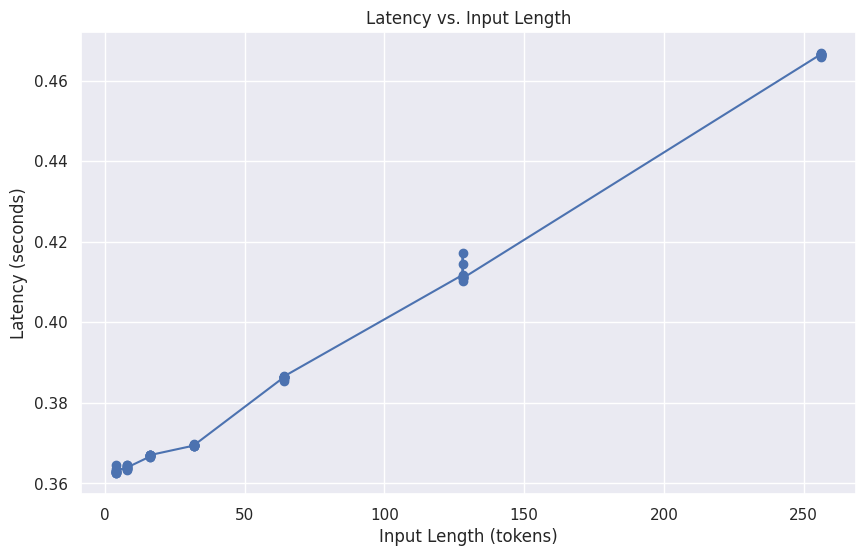

: 

In [ ]:
### Cell 6: Experiment 2 - Effect of Input Length on Prefilling Latency
print("--- Experiment 2: Input length vs. prefill latency ---")

LATENCY_INPUT_LENGTHS = [2 ** i for i in range(2, 9)]
NUM_WARMUP = 10
NUM_TRIALS = 10
MAX_NEW_TOKENS = 16

latency_records = []

for input_length in LATENCY_INPUT_LENGTHS:
    inputs = tokenizer("apple " * input_length, return_tensors="pt").to(DEVICE)
    for _ in range(NUM_WARMUP):
        with torch.no_grad():
            model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=MAX_NEW_TOKENS)
    for _ in range(NUM_TRIALS):
        start_time = time.time()
        with torch.no_grad():
            model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=MAX_NEW_TOKENS)
        latency_records.append(
            {
                "length": input_length,
                "latency": time.time() - start_time
            }
        )

df_latency = pd.DataFrame(latency_records)

summary_latency = df_latency.groupby("length").agg({"latency": ["mean", "std"]})
plt.figure(figsize=(10, 6))
plt.plot(df_latency["length"], df_latency["latency"], marker='o', linestyle='-', color='b')
plt.xlabel("Input Length (tokens)")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs. Input Length")
plt.grid(True)
plt.savefig(f"{FIGURES_DIR}/task1_step3__latency.png")
plt.show()


--- Experiment 3: Real-time memory trace ---


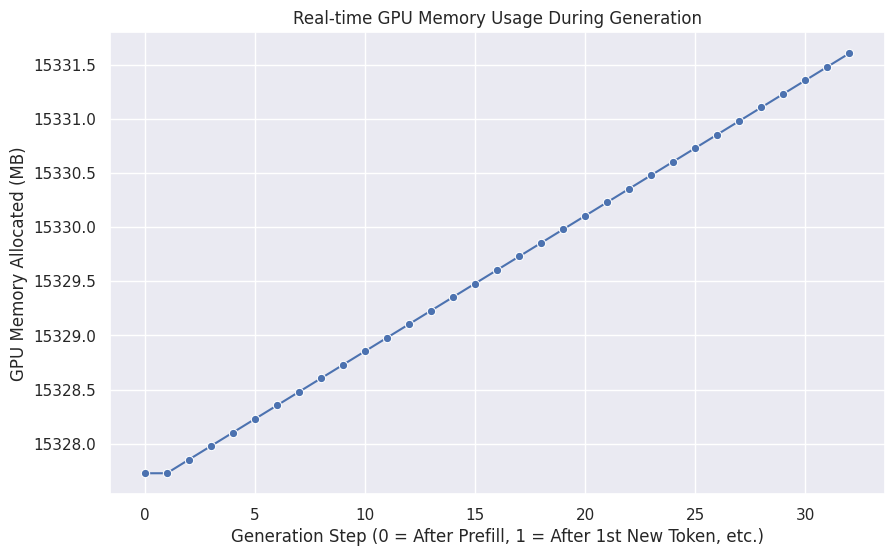

    generation_step     memory_mb
28               28  15331.104492
29               29  15331.229492
30               30  15331.354492
31               31  15331.479492
32               32  15331.604492


In [9]:
### Cell 8: Experiment 3 - Real-time GPU Memory Usage During Generation
print("--- Experiment 3: Real-time memory trace ---")

df_memory_steps = pd.DataFrame()

if DEVICE.type != "cuda":
    print("Skipped: requires GPU trace from the previous cell.")
else:
    MAX_GENERATION_LENGTH = 32
    PROMPT = "The sum of 2 and 2 is "
    inputs = tokenizer(PROMPT, return_tensors="pt").to(DEVICE)
    INPUT_LENGTH = inputs['input_ids'].shape[1]

    class MemoryUsageCallback(StoppingCriteria):
        def __init__(self, device):
            self.device = device
            self.memory_usage_mb = []
            self.initial_memory_captured = False

        def __call__(self, input_ids, scores, **kwargs):
            if not self.initial_memory_captured:
                self.memory_usage_mb.append(torch.cuda.memory_allocated(self.device) / 1024**2)
                self.initial_memory_captured = True
            self.memory_usage_mb.append(torch.cuda.memory_allocated(self.device) / 1024**2)
            return False

        def get_memory_trace(self):
            return self.memory_usage_mb

    NUM_WARMUP_GEN = 5
    MAX_NEW_TOKENS_WARMUP = 10

    for _ in range(NUM_WARMUP_GEN):
        with torch.no_grad():
            model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=MAX_NEW_TOKENS_WARMUP)

    torch.cuda.empty_cache()
    callback = MemoryUsageCallback(DEVICE)

    with torch.no_grad():
        model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=MAX_GENERATION_LENGTH, stopping_criteria=[callback])

    memory_trace = callback.get_memory_trace()

    df_memory_steps = pd.DataFrame({
        'generation_step': list(range(len(memory_trace))),
        'memory_mb': memory_trace
    })
    df_memory_steps.to_csv(f"{RESULTS_DIR}/task1_step5__memory.csv", index=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df_memory_steps, x='generation_step', y='memory_mb', ax=ax, marker='o')
    ax.set_xlabel("Generation Step (0 = After Prefill, 1 = After 1st New Token, etc.)")
    ax.set_ylabel("GPU Memory Allocated (MB)")
    ax.set_title("Real-time GPU Memory Usage During Generation")
    ax.grid(True)
    plt.savefig(f"{FIGURES_DIR}/task1_step5__memory.png")
    plt.show()
    print(df_memory_steps.tail())

In [10]:
### Cell 9: Space Complexity Verification
print("--- Space complexity verification ---")

if DEVICE.type != "cuda":
    print("Skipped: requires GPU trace from the previous cell.")
elif df_memory_steps.empty:
    print("No memory trace data available. Run Experiment 3 before this analysis.")
else:
    x = df_memory_steps['generation_step']
    y = df_memory_steps['memory_mb']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    print(f"\nLinear Regression Results for KV Cache Space Complexity:")
    print(f"  Slope (MB/token): {slope:.4f}")
    print(f"  Intercept (MB): {intercept:.4f}")
    print(f"  R-squared value: {r_value**2:.4f}")


--- Space complexity verification ---

Linear Regression Results for KV Cache Space Complexity:
  Slope (MB/token): 0.1243
  Intercept (MB): 15327.6188
  R-squared value: 0.9997


In [ ]:
### Cell 10: List all generated artifacts for Task 1
print("Task 1 complete. Generated artifacts:")

if os.path.isdir(RESULTS_DIR):
    print(f"\nFiles in {RESULTS_DIR}:")
    for filename in os.listdir(RESULTS_DIR):
        print(f"- {filename}")

if os.path.isdir(FIGURES_DIR):
    print(f"\nFiles in {FIGURES_DIR}:")
    for filename in os.listdir(FIGURES_DIR):
        print(f"- {filename}")


Task 1 complete. Generated artifacts:

Files in ./results:
- .gitkeep
- task1_step2__full.csv
- task1_step2__summary.csv
- task1_step5__memory.csv

Files in ./figures:
- .gitkeep
- task1_step3__latency.png
- task1_step5__memory.png


: 